## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import preprocessing
import visualization
import utils
from easydict import EasyDict

## DATA PREPROCESSING

In [2]:
# Training and testing names are given by a variable named 'splits'
from utils import splits

data = {}; data_test = {}
name = ['0zt','8zt','16zt'] # Folders name
for n in name:
    data, data_test = preprocessing.generate_signal_dictionary(data, data_test, scale = False, outlier_filter = False, data_splits = splits, name=n)
    
print(f'There are {len(data)} recordings used for training and {len(data_test)} recordings used for testing')

There are 53 recordings used for training and 15 recordings used for testing


In [3]:
window_size = 1024
hop_length = 256

In [4]:
df, l = preprocessing.generate_model_data(data_dictionary=data, method = 'fft', window_size = window_size, hop_length= hop_length, verbose = True)
df_test, l_test = preprocessing.generate_model_data(data_dictionary=data_test, method = 'fft', window_size = window_size, hop_length= hop_length, verbose = True)

Signal processing method: fft
Data shape: (602026, 513)
Class distribution (label/n_obs): 1: 41999, 2: 63321, 4: 29203, 5: 375304, 6: 58007, 7: 14354, 8: 19838
Signal processing method: fft
Data shape: (171005, 513)
Class distribution (label/n_obs): 1: 10144, 2: 21733, 4: 6087, 5: 98527, 6: 16398, 7: 11326, 8: 6790


# TRAINING 

In [5]:
from models import MLP
from train import Trainer

In [6]:
X = utils.get_two_levels_split(df,l)
y = utils.get_two_levels_split(df_test,l_test)

In [128]:
X1 = X.level1; y1 = y.level1
X2 = X.level2; y2 = y.level2

In [27]:
info = EasyDict({'device': 'cuda', 'n_classes': 7, 'num_epochs': 10, 'learning_rate': 0.0001,'batch_size': 128,'model_type':'mlp', 'seq_length': 513})
model1 = MLP(n_classes = info.n_classes, input_size = info.seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters())

trainer1 = Trainer(X1,y1,model1,criterion,optimizer,info)
trainer1.get_loader()
trainer1.train()
trainer1.save_checkpoint('MLP - fft - 1024-256 - level1 - 09-01-2024.pth')

Obtaning data loaders...
Train, validate, test lengths: (481620, 120406, 171005)
Input shape: torch.Size([64, 513])
Initialize...
Training...
Epoch [1/10], loss: 0.2605, validation accuracy: 0.9734
Epoch [10/10], loss: 0.0434, validation accuracy: 0.9876
Testing...
Accuracy : 0.9788
Balanced accuracy: 0.9796
Predicted labels: (array([0, 1], dtype=int64), array([73833, 97172], dtype=int64))
True labels: (array([0, 1]), array([72478, 98527], dtype=int64))

Finished!


In [29]:
info = EasyDict({'device': 'cuda', 'n_classes': 7, 'num_epochs': 50, 'learning_rate': 0.0001,'batch_size': 128,'model_type':'mlp', 'seq_length': 513})
model2 = MLP(n_classes = info.n_classes, input_size = info.seq_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters())

trainer2 = Trainer(X2,y2,model2,criterion,optimizer,info)
trainer2.get_loader()
trainer2.train()
trainer2.save_checkpoint('MLP - fft - 1024-256 - level2 - 09-01-2024.pth')

Obtaning data loaders...
Train, validate, test lengths: (181377, 45345, 72478)
Input shape: torch.Size([100, 513])
Initialize...
Training...
Epoch [1/50], loss: 1.1189, validation accuracy: 0.8621
Epoch [11/50], loss: 0.2766, validation accuracy: 0.9170
Epoch [21/50], loss: 0.2327, validation accuracy: 0.9263
Epoch [31/50], loss: 0.2133, validation accuracy: 0.9300
Epoch [41/50], loss: 0.2014, validation accuracy: 0.9318
Epoch [50/50], loss: 0.1927, validation accuracy: 0.9338
Testing...
Accuracy : 0.8675
Balanced accuracy: 0.8627
Predicted labels: (array([0, 1, 2, 3, 4, 5], dtype=int64), array([10895, 24133,  5807, 14831,  9830,  6982], dtype=int64))
True labels: (array([0, 1, 2, 3, 4, 5], dtype=int64), array([10144, 21733,  6087, 16398, 11326,  6790], dtype=int64))

Finished!


# PREDICTING

In [7]:
from test import Classifier
from models import MLP

models = [MLP(input_size=513,n_classes=7), MLP(input_size=513,n_classes=7)]
path = ["MLP - fft - 1024-256 - level1 - 09-01-2024.pth","MLP - fft - 1024-256 - level2 - 09-01-2024.pth"]
device = 'cuda'

test_configs = EasyDict({'method':'fft', 'model_type':'mlp','scope':4, 'window_size':1024, 'hop_length':256})
clf = Classifier(models, device)
clf.load_checkpoint(path)
clf.load_configs(test_configs)

Two level classifier
Configurations loaded.


In [9]:
name = ['0zt','8zt','16zt']
acc = []
b_acc = []
for n in name:
    for fn in splits[n][1]:
        print(fn)
        wave_array,ana = data_test[fn]
        clf.predict(wave_array, ana,)
        acc.append(clf.acc)
        b_acc.append(clf.b_acc)

Accuracy:  0.949
Balanced accuracy:  0.873


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.976
Balanced accuracy:  0.846


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.925
Balanced accuracy:  0.788


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.849
Balanced accuracy:  0.802


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.902
Balanced accuracy:  0.707
Accuracy:  0.76
Balanced accuracy:  0.776
Accuracy:  0.925
Balanced accuracy:  0.916
Accuracy:  0.913
Balanced accuracy:  0.814


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.971
Balanced accuracy:  0.791


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.934
Balanced accuracy:  0.926
Accuracy:  0.899
Balanced accuracy:  0.856


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.922
Balanced accuracy:  0.805


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.982
Balanced accuracy:  0.825


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.925
Balanced accuracy:  0.916
Accuracy:  0.967
Balanced accuracy:  0.853
Average accuracy/balanced accuracy over 15 test files are 0.92 and 0.833, resp.


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [10]:
avg_acc = round(sum(acc)/len(acc), 3)
avg_b_acc = round(sum(b_acc)/len(b_acc), 3)
print(f'Average accuracy/balanced accuracy over 15 test files are {avg_acc} and {avg_b_acc}, resp.')

Average accuracy/balanced accuracy over 15 test files are 0.92 and 0.833, resp.


# VISUALIZING

Accuracy:  0.949
Balanced accuracy:  0.873


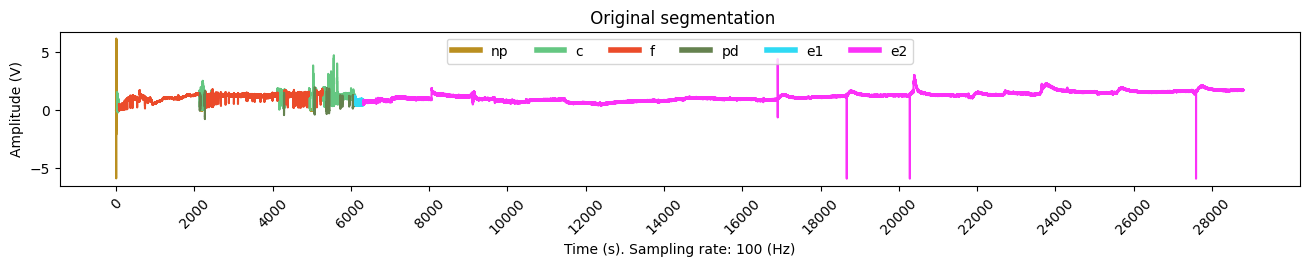

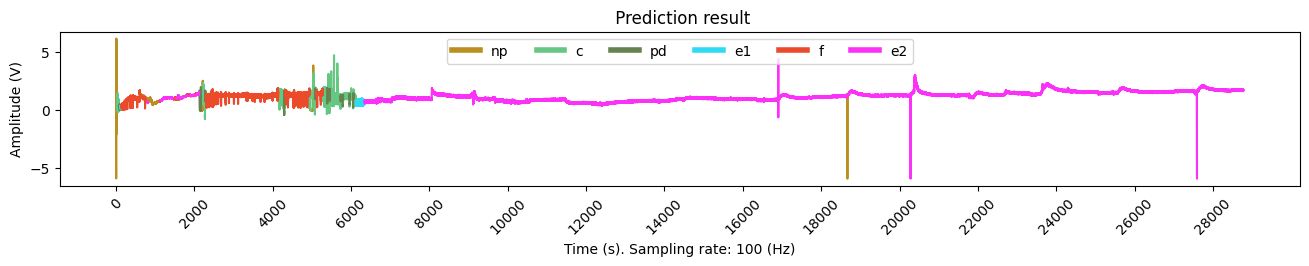

In [11]:
file = splits['0zt'][1][0]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.902
Balanced accuracy:  0.707


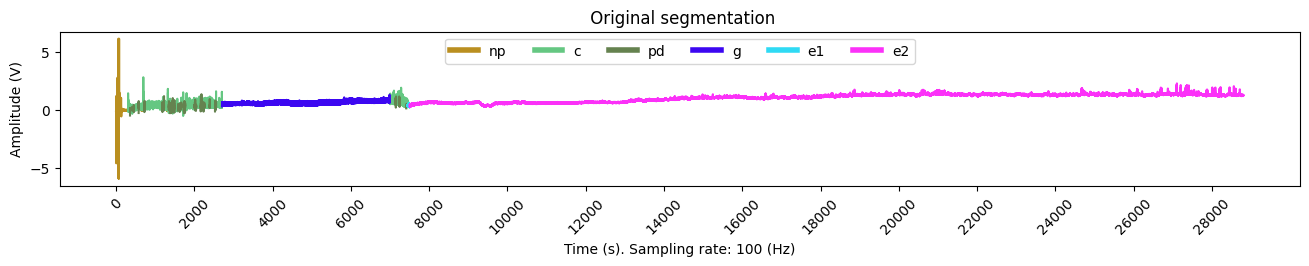

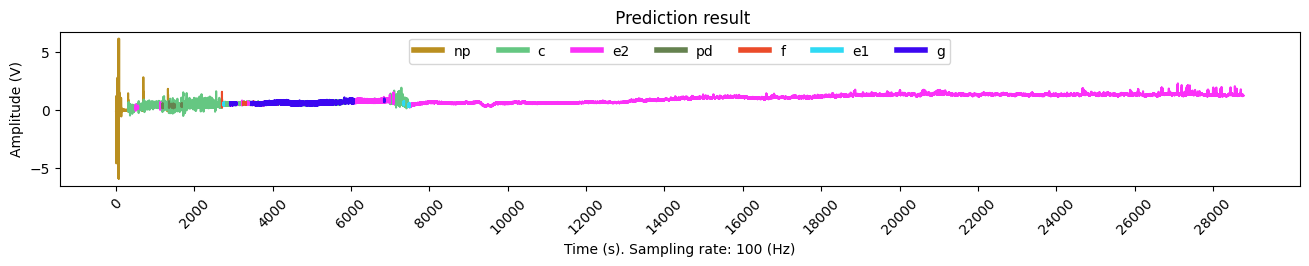

In [12]:
file = splits['0zt'][1][4]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

Accuracy:  0.913
Balanced accuracy:  0.814


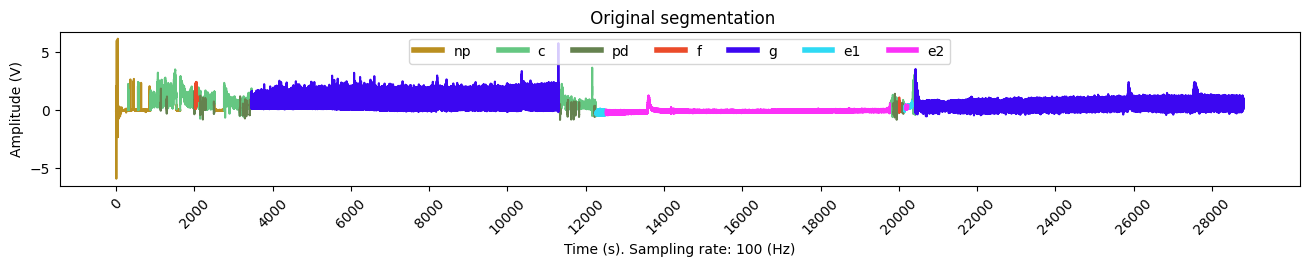

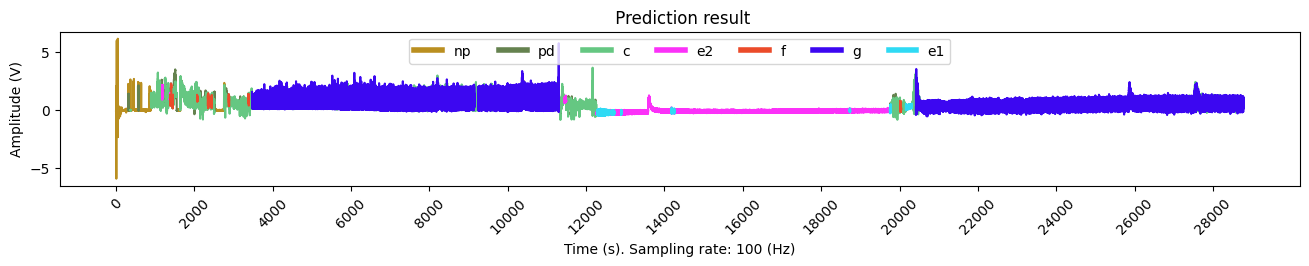

In [13]:
file = splits['8zt'][1][2]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.934
Balanced accuracy:  0.926


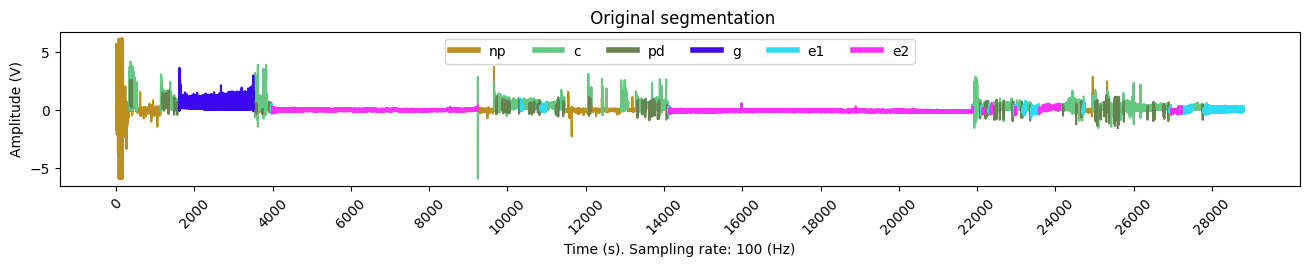

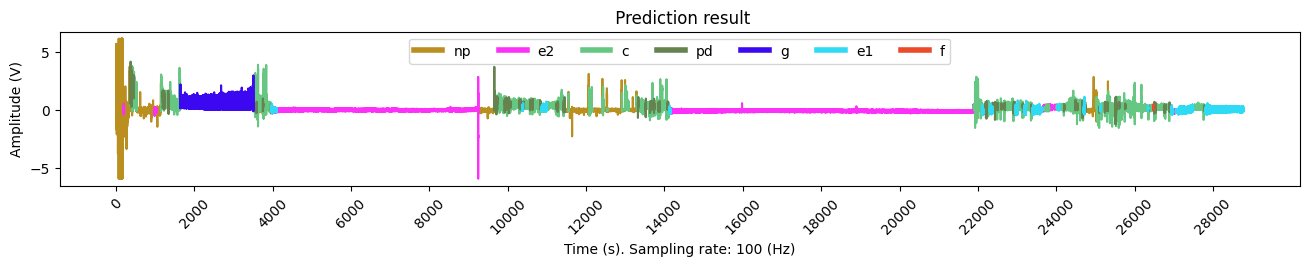

In [14]:
file = splits['8zt'][1][4]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.982
Balanced accuracy:  0.825


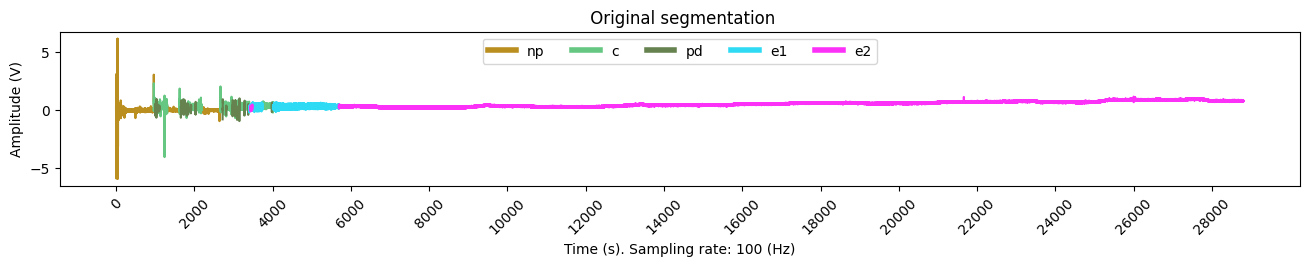

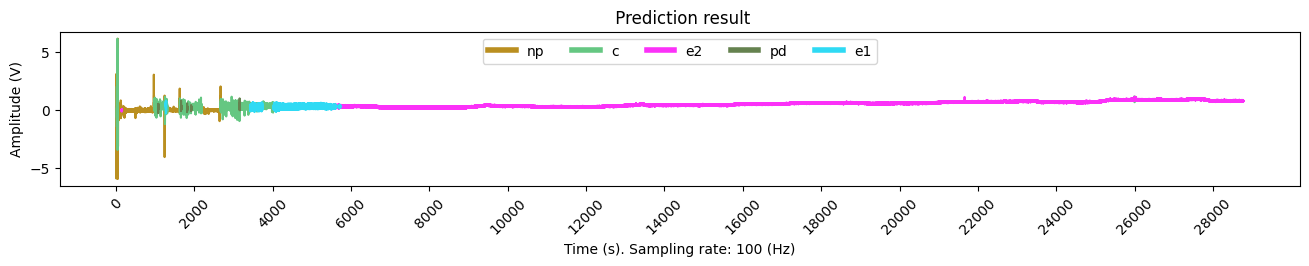

In [16]:
file = splits['16zt'][1][2]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

# Final comment

Our model use direct fft coefficients as input and it has given pretty promising results.

However, there are many further things to improve

- Data augmentation: We could try to oversample the short and minor class such as 'pd' to emphasizes this behavior
- There are noises in the signals that has to be considered, for example: 'np' waves should looks like a flat line but there are instances that 'np' waves amplitudes fluctuate arond 1V
- Our model has not taken into account the relation between waveforms. For example, you can only find 'pd' waves in between pathway 'c' waves, or 'e1' is usually followed up by 'e2', ...